<h1 style="text-align:right">GROUP 7</h1>

## Exercise 1 - Smoothing and Interpolation

## 1 Introduction

### 1.1 Background
A medical image is essentially a grid of discrete intensity values representing the measured signal at one specific location (pixel). These measurements are limited by the resolution of the imaging device and often contain noise from the acquisition process. To improve spatial resolution, reduce acquisition noise, and adapt images for tasks such as segmentation, registration, or quantitative analysis, two common techniques can be applied: **interpolation** and **smoothing**.  
Interpolation reconstructs a continuous image that passes exactly through the original intensity values, allowing estimation of intensities at pixel locations between measured points, in order, for example, to generate intermediate slices or resample to a different resolution. On the other hand, smoothing reduces noise by creating a continuous approximation of the data that does not necessarily match every original point, enhancing anatomical structures and improving the robustness of further analysis.

This project explores the use of B-splines for smoothing and interpolation in medical imaging. 
B-splines are piecewise polynomial functions that can be defined recursively by convolving a constant box function (zeroth-order spline **[eq.1-2]**). They provide a flexible way to reconstruct continuous signals from discrete samples while controlling smoothness, making them widely used for tasks such as image resampling, noise reduction, and registration.

**Equation (1)**  

$
\beta_0(x) =
\begin{cases}
1, & |x| < \frac{1}{2} \\
\frac{1}{2}, & |x| = \frac{1}{2} \\
0, & \text{otherwise}
\end{cases}
$

**Equation (2)**  

$
\beta_p(x) = \underbrace{(\beta_0 * \beta_0 * \cdots * \beta_0)}_{\text{(p+1) repeated convolutions}}(x)
$

where $*$ denotes convolution. Examples include the linear B-spline ($p=1$) and the widely used cubic B-spline ($p=3$).  

The work is organized into five tasks:  
1. **B-spline basis functions** – implementation and visualization of uniform B-splines of order 0, 1, and 3.  
2. **1D smoothing** – applying cubic B-spline basis functions to smooth a noisy 1D signal.  
3. **1D interpolation** – reconstructing a continuous signal from discrete samples using B-spline interpolation of different orders.  
4. **2D smoothing** – extending the approach to smooth a full MRI slice, both via Kronecker product and separability of basis functions.  
5. **2D interpolation** – interpolating a 2D image segment using B-splines of order 0, 1, and 3.  

By gradually extending from simple 1D cases to more complex 2D applications, this exercise highlights both the mathematical foundations and the practical impact of B-spline methods in image processing.

### 1.2 Input data and code hints

In [ ]:
# Import libraries
import numpy as np
import nibabel as nib
from matplotlib import pyplot as plt

np.set_printoptions(suppress=True)
plt.ion()

#Load the 3D volume (MRI brain scan) and extract the 2D slice (75):
T1_file = 'T1-brain.nii.gz'
T1_nib = nib.load( T1_file )
data = T1_nib.get_fdata()

img = data[:, :, 75]
T = np.flipud(img.T)

#plt.axis('off')
#plt.imshow(T, cmap='bone');

Extract the 1D signal at the middle row of the slice:

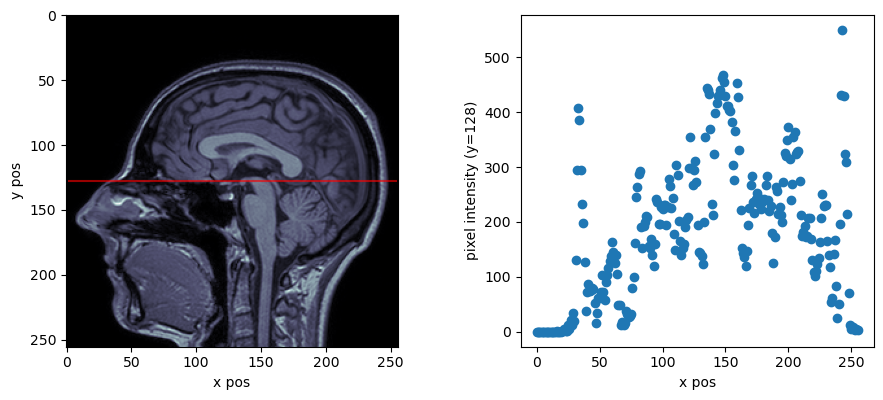

In [ ]:
row = round( T.shape[0] / 2 )
t = T[row, :] #pixel intensity signal at row y = 128

N = t.shape[0] # 256
x = np.arange(0, N)

# plot
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
fig.tight_layout(pad=5.0)

im = ax[0].imshow(T, cmap='bone')
ax[0].imshow(T, cmap='bone')
ax[0].hlines(row, xmin=1, xmax=255, alpha=0.6, color='r')
ax[0].set_xlabel('x pos')
ax[0].set_ylabel('y pos')

ax[1].scatter(x, t)
ax[1].set_xlabel('x pos')
ax[1].set_ylabel('pixel intensity (y={})'.format(row))

plt.show();

## 2 Exercises
### Task 1: B-splines basis functions
Implement a function that evaluates the uniform B-spline of orders 0, 1 and 3 at the locations provided in a vector $\mathbf{x}$. This function should return a vector $\mathbf{y}$ that is the same length as $\mathbf{x}$.

In [4]:
def eval_BSpline(x, order=0):
    """
    Evaluates the uniform B-spline of order "order" at the locations in vector "x"
    Order 0: box function
    Order 1: triangle function
    Order 3: cubic B-spline
    """
    x = np.array(x, dtype=float)
    
    #Initialize y (zeros vector)
    y = np.zeros_like(x)

    if order == 0:
        # if |x| < 0.5, B0(x) = 1, else B0 = 0
        y[np.abs(x) < 0.5] = 1.0

    elif order == 1:
        # if |x|<1, B1(x) = 1 - |x|, else B1 = 0
        y = np.maximum(1 - np.abs(x), 0)

    elif order == 3:
        # Cubic B-spline piecewise definition
        ax = np.abs(x)
        y[ax < 1] = 2/3-(ax[ax < 1])**2+(ax[ax < 1])**3/2
        y[(ax >= 1) & (ax < 2)] = (2 - ax[(ax >= 1) & (ax < 2)])**3 / 6
    else:
        raise ValueError("Only orders 0, 1, and 3 are supported.")
    return y

The function `eval_BSpline` implements the evaluation of uniform B-spline basis functions of 3 orders according to the following definitions:  

- **order 0**

$
\beta_1(x) = 
\begin{cases} 
1, & -\tfrac{1}{2} < x < \tfrac{1}{2} \\ 
\tfrac{1}{2}, & |x| = \tfrac{1}{2} \\
0, & \text{otherwise} 
\end{cases}
$

- **Order 1 (linear interpolation)**:

$
\beta_1(x) = 
\begin{cases} 
1 - |x|, & |x| < 1 \\
0, & \text{otherwise} 
\end{cases}
$

**Note**. The value 1-|x| is positive when |x| < 1 and negative when |x| < 1. Therefore, max(1 - |x|, 0) replaces any negative values with 0, implementing the “otherwise 0” part of the definition.

- **Order 3 (cubic interpolation)**:

$
\beta_3(x) = 
\begin{cases} 
\frac{2}{3} - |x|^2 + \tfrac{1}{2}|x|^3, & |x| < 1 \\
\frac{(2 - |x|)^3}{6}, & 1 \leq |x| < 2 \\
0, & \text{otherwise} 
\end{cases}
$

Use `eval_BSpline` to plot the uniform B-spline of orders 0, 1 and 3 at locations:  $\mathbf{x} = [-3.0,-2.99,-2.98, \ldots, 2.99,3.0]$.

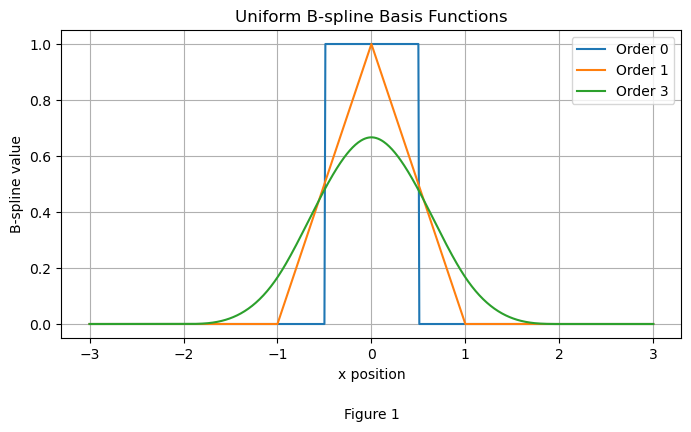

In [ ]:
# Test points
x = np.arange(-3.0, 3.01, 0.01)

plt.figure(figsize=(8,4))

for order in [0, 1, 3]:
    y = eval_BSpline(x, order)
    plt.plot(x, y, label=f"Order {order}")

plt.title("Uniform B-spline Basis Functions")
plt.xlabel("x position")
plt.ylabel("B-spline value")
plt.grid(True)
plt.legend()

plt.text(0.5, -0.25, "Figure 1", ha='center', va='center', transform=plt.gca().transAxes)

plt.show()

#### Discussion  
The implementation and visualization of B-spline basis functions confirm the theoretical differences between orders. The zeroth-order B-spline (order 0) is a piecewise constant “box” function with discontinuities at the edges. The linear B-spline (order 1) is a triangle-shaped function, continuous but with slope jumps at the boundaries. The cubic B-spline (order 3) is smooth, continuous up to the second derivative, and has a wider support. As expected, the support of the basis functions increases with order, affecting more neighboring points. Plotting these functions shows that as the B-spline order increases, more neighboring points affect the value at a given location, with the closest points carrying higher weights, resulting in a smoother spline. The plotted curves (Figure 1) illustrate these properties clearly and provide a foundation for subsequent smoothing and interpolation tasks.

---
### Task 2: 1D Smoothing
Using the function `eval_BSpline` for evaluating a uniform B-spline of order 3, generate $M=6$ basis functions covering the entire domain $x=0,1,\ldots, 255$ of the 1D signal $\mathbf{t}$ defined in the introduction (which has length $N=256$). The basis functions should be scaled by a factor $h=(N-1)/(M-1)$, and shifted to be $h$ units apart (see book). Collect the obtained basis functions in a $N \times M$ matrix $\boldsymbol{\Phi}$, and plot them.

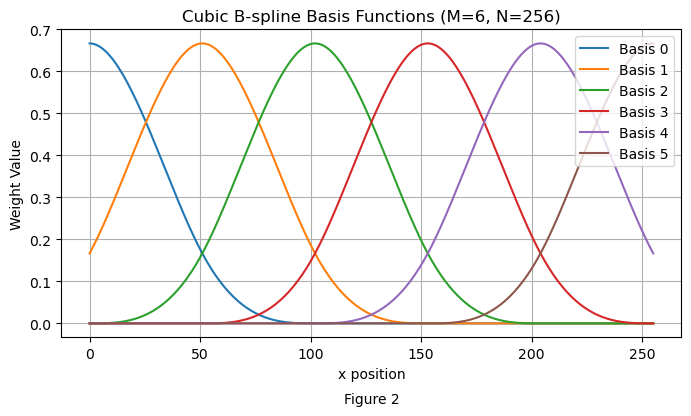

In [ ]:
M = 6
# This scaling factor (51) ensures that the basis function 
# width matches the spacing needed to spread evenly across the full signal.
h = (N - 1) / (M - 1)

# Domain
x = np.arange(0,N)

# Build basis functions matrix Φ (N x M) where each column is a basis 
# function evaluated at all points of the domain
Phi = np.zeros((N, M)) # [256x6]

for m in range(M):
    """
    Note.
    d/h converts the x-coords into basis function units while subtracting 
    m centers each basis function at a different integer m in the scaled 
    coordinate system. Therefore, d/h - m effectively shifts the m-th 
    basis function so that it is centered at the right position along the 
    domain:
     m=0 → 1st basis function centered at 0
     m=1 → 2nd basis function centered at 1
     etc..
     
     """
    Phi[:, m] = eval_BSpline(x/h-m, order=3)

# Plot
plt.figure(figsize=(8, 4))
for m in range(M):
    plt.plot(x, Phi[:, m], label=f"Basis {m}")
plt.title("Cubic B-spline Basis Functions (M=6, N=256)")
plt.xlabel("x position")
plt.ylabel("Weight Value")
plt.legend(loc='upper right')
plt.grid(True)
plt.text(0.5, -0.2, "Figure 2", ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

Compute:
- the smoothing matrix: $\mathbf{S} = \boldsymbol{\Phi} (\boldsymbol{\Phi}^T \boldsymbol{\Phi})^{-1} \boldsymbol{\Phi}^T$
- the smoothed signal:  $\mathbf{\hat{t}} = \mathbf{S} \mathbf{t}$

Plots the results and the middle row of the smoothing matrix.  ***Hint:*** To compute the solution of a linear equation of the form Ax = b, you can use the following numpy function: `np.linalg.solve(A, b)`.

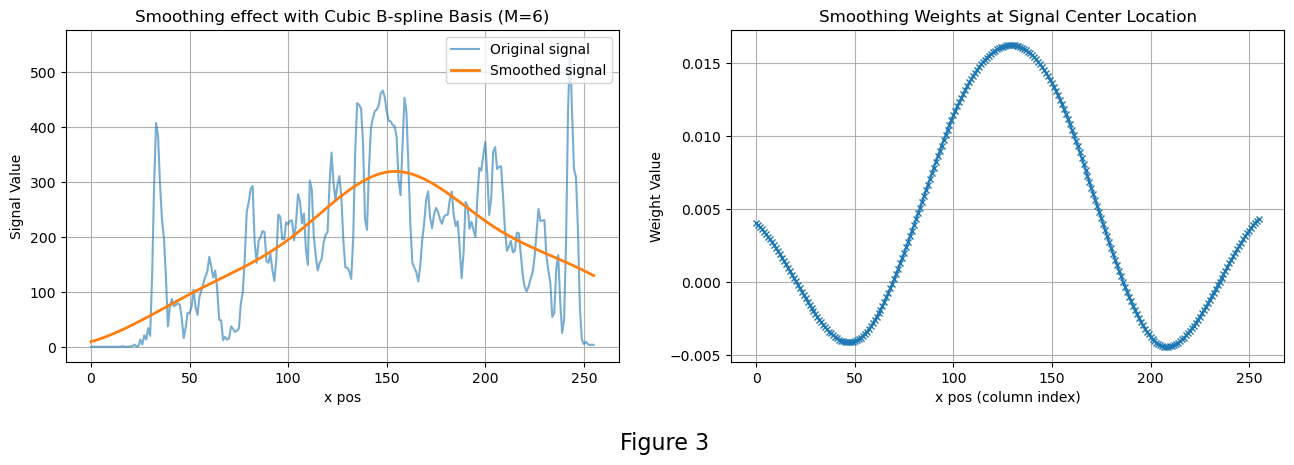

In [7]:
# Compute smoothing matrix S
A = Phi.T @ Phi # MxM

# Solve AX = Phi^T -> X = A^-1 Phi^T = (Phi.T @ Phi)^-1 @ Phi^T
X = np.linalg.solve(A, Phi.T) 
S = Phi @ X                   # smooth matrix
t_smooth = S @ t              # smoothed signal

# Plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
fig.tight_layout(pad=5.0)

# Left plot: original and smoothed signal
ax[0].plot(x, t, label="Original signal", alpha=0.6)
ax[0].plot(x, t_smooth, label="Smoothed signal", linewidth=2)
ax[0].set_title("Smoothing effect with Cubic B-spline Basis (M=6)")
ax[0].set_xlabel("x pos")
ax[0].set_ylabel("Signal Value")
ax[0].legend(loc='upper right')
ax[0].grid(True)

# Right plot: middle row of smoothing matrix
ax[1].plot(S[N//2, :], marker="x", markersize=4)
ax[1].set_title("Smoothing Weights at Signal Center Location")
ax[1].set_xlabel("x pos (column index)")
ax[1].set_ylabel("Weight Value")
ax[1].grid(True)

fig.text(0.5, 0.0, "Figure 3", ha='center', va='bottom', fontsize=16)
plt.show()

Now repeat the same experiment when more basis functions are used: $M=16$ and $M=52$. Explain how the smoothing behavior change.

#### case M=16:

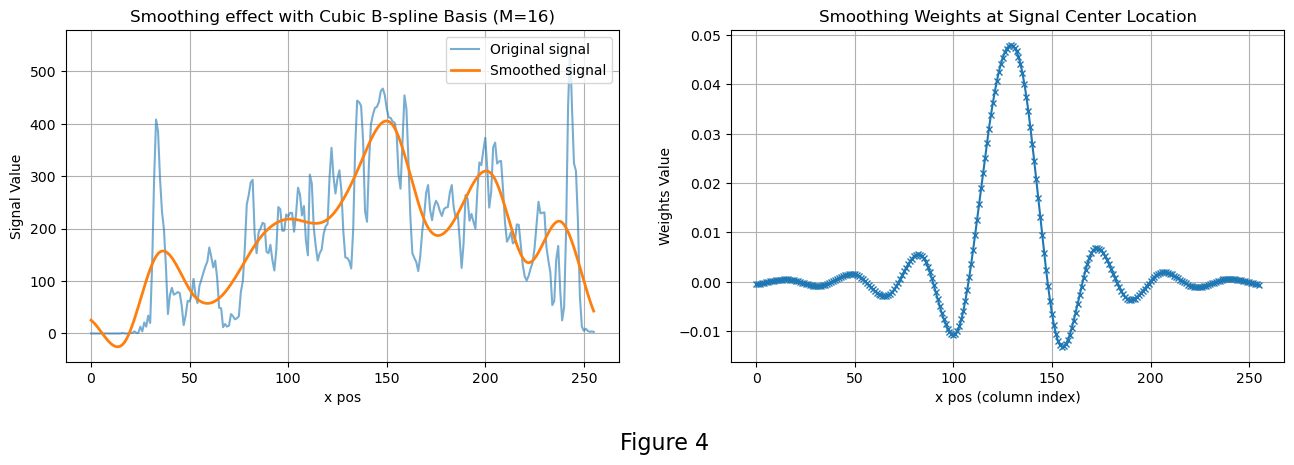

In [8]:
M = 16
h = (N - 1) / (M - 1)   # h = 17

# Build basis matrix Φ (N x M)
Phi = np.zeros((N, M)) # [256x16]

for m in range(M):
    Phi[:, m] = eval_BSpline(x/h-m, order=3)

# Compute smoothing matrix S
A = Phi.T @ Phi
X = np.linalg.solve(A, Phi.T)
S = Phi @ X
t_smooth = S @ t

# Plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
fig.tight_layout(pad=5.0)

# Left plot: original and smoothed signal
ax[0].plot(x, t, label="Original signal", alpha=0.6)
ax[0].plot(x, t_smooth, label="Smoothed signal", linewidth=2)
ax[0].set_title("Smoothing effect with Cubic B-spline Basis (M=16)")
ax[0].set_xlabel("x pos")
ax[0].set_ylabel("Signal Value")
ax[0].legend(loc='upper right')
ax[0].grid(True)

# Right plot: middle row of smoothing matrix
ax[1].plot(S[N//2, :], marker="x", markersize=4)
ax[1].set_title("Smoothing Weights at Signal Center Location")
ax[1].set_xlabel("x pos (column index)")
ax[1].set_ylabel("Weights Value")
ax[1].grid(True)

fig.text(0.5, 0.0, "Figure 4", ha='center', va='bottom', fontsize=16)
plt.show()

#### case M=52:

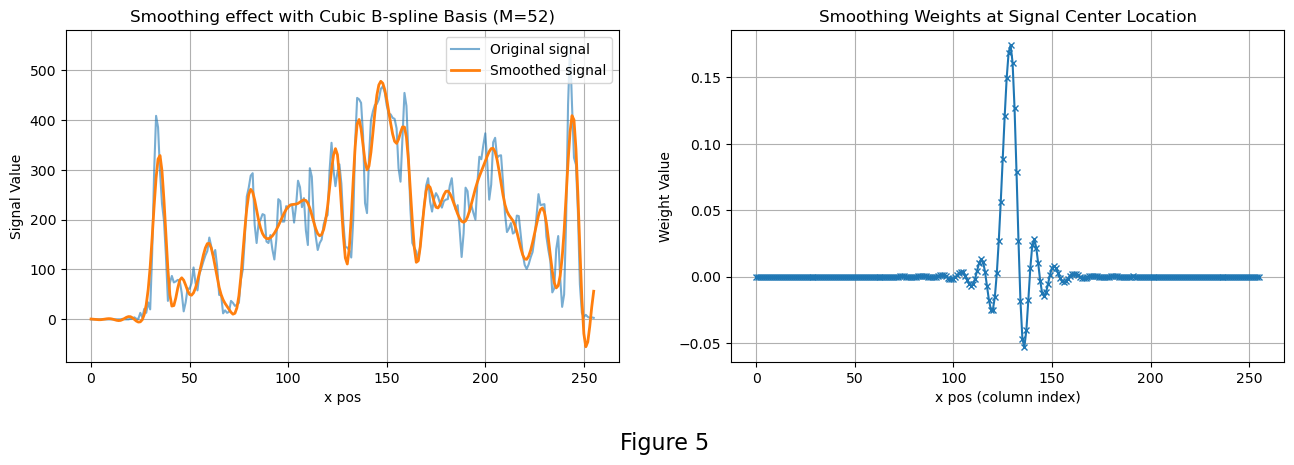

In [9]:
M = 52
h = (N - 1) / (M - 1)   # h = 5

# Build basis matrix Φ (N x M)
Phi = np.zeros((N, M)) # [256x52]

for m in range(M):
    Phi[:, m] = eval_BSpline(x/h-m, order=3)

# Compute smoothing matrix S
A = Phi.T @ Phi
X = np.linalg.solve(A, Phi.T)
S = Phi @ X
t_smooth = S @ t  

# Plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
fig.tight_layout(pad=5.0)

# Left plot: original and smoothed signal
ax[0].plot(x, t, label="Original signal", alpha=0.6)
ax[0].plot(x, t_smooth, label="Smoothed signal", linewidth=2)
ax[0].set_title("Smoothing effect with Cubic B-spline Basis (M=52)")
ax[0].set_xlabel("x pos")
ax[0].set_ylabel("Signal Value")
ax[0].legend(loc='upper right')
ax[0].grid(True)

# Right plot: middle row of smoothing matrix
ax[1].plot(S[N//2, :], marker="x",markersize=4)
ax[1].set_title("Smoothing Weights at Signal Center Location")
ax[1].set_xlabel("x pos (column index)")
ax[1].set_ylabel("Weight Value")
ax[1].grid(True)

fig.text(0.5, 0.0, "Figure 5", ha='center', va='bottom', fontsize=16)
plt.show()

#### Discussion
The function created in Task 1 was used to generate M=6 B-splines of order 3 (basis functions) that spanned the domain 0-255 with a scaling factor of $h = 51$. The smoothing matrix (S) was computed and applied to the signal (pixel intensity) of the middle row of the image ($row = 128$), and the weight on neighbouring pixels at the signal center was plotted to understand the extent of the effect of the smoothing [**Fig.3**]. The process was then repeated, increasing the number of basis functions (M). With M=16 [**Fig.4**] and M=52 [**Fig.5**], the individual basis functions become narrower and more closely spaced along the signal domain, allowing finer details of the original signal to be captured. As a result, the smoothed signals more closely follow the original signal while still reducing high-frequency noise. Examining the middle row of the corresponding smoothing matrices shows that the influence of each point is now concentrated over fewer neighbors, producing a more localized weighting pattern. These observations confirm that increasing M reduces smoothing and increases resolution, providing control over the trade-off between smoothness and fidelity to the original data. In medical imaging, this balance is critical because oversmoothing can erase small anatomical structures, whereas too much detail may include acquisition noise.

---
### Task 3: 1D Interpolation
Implement B-spline interpolation of the 1D signal $\mathbf{t}$, by evaluating the function $y( x, \mathbf{w})$ at locations $x = [120, 120.01, 120.02, \ldots 140]$. Show your results, along with the corresponding part of the signal $\mathbf{t}$, for three different orders of B-splines: 0, 1 and 3.

In [10]:
def bspline_interpolate(t, x_eval, order):
    """
    1D B-spline interpolation.
    t: array of samples (length N)
    x_eval: array of positions where to evaluate
    order: spline order (0=nearest, 1=linear, 3=cubic, …)
    """
    N = len(t)
    x_nodes = np.arange(N)

    # Build Phi at sample nodes
    Phi = np.zeros((N, N))
    for i in range(N):        # row = sample position
        for j in range(N):    # column = basis centered at j
            Phi[i, j] = eval_BSpline(x_nodes[i] - j, order)

    # Solve for coefficients
    if order <= 1:
        c = t.copy()   # for 0,1 coefficients == samples
    else:
        c = np.linalg.solve(Phi, t)

    # Evaluate at x_eval
    y_eval = np.zeros_like(x_eval, dtype=float)
    for i, x in enumerate(x_eval):
        for j in range(N):
            y_eval[i] += c[j] * eval_BSpline(x - j, order)

    return y_eval


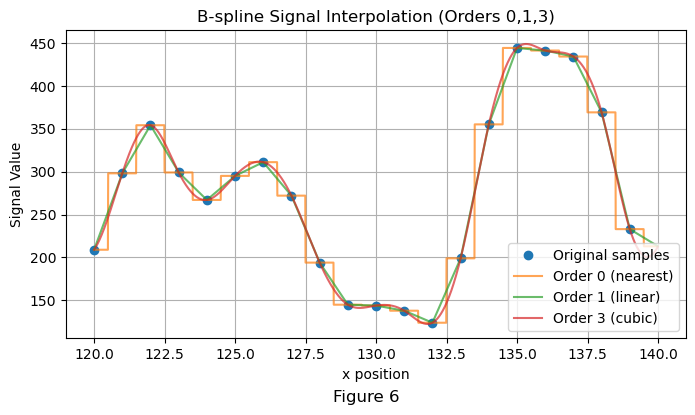

In [11]:
x_eval = np.arange(120, 140, 0.01)

# Interpolation for orders 0,1,3
y0 = bspline_interpolate(t, x_eval, order=0)
y1 = bspline_interpolate(t, x_eval, order=1)
y3 = bspline_interpolate(t, x_eval, order=3)

# Plot results
plt.figure(figsize=(8,4))

# Original discrete samples in the interval
plt.plot(x[120:140], t[120:140], "o", label="Original samples")

plt.plot(x_eval, y0, label="Order 0 (nearest)", alpha=0.7)
plt.plot(x_eval, y1, label="Order 1 (linear)", alpha=0.7)
plt.plot(x_eval, y3, label="Order 3 (cubic)", alpha=0.7)

plt.title("B-spline Signal Interpolation (Orders 0,1,3)")
plt.xlabel("x position")
plt.ylabel("Signal Value")
plt.legend(loc="lower right")
plt.grid(True)
plt.figtext(0.5, -0.05, "Figure 6", ha="center", fontsize=12)
plt.show()

#### Discussion

In this task, a sample of the signal t, $x = [120, 120.01, 120.02, \ldots 140]$, was interpolated. By interpolating a discrete signal, the spline is forced to pass through all original samples (turns continuous), where each point is calculated through a weighted version of the original points. The closer the original point is to the position in question, the more it influences its value (higher weight value).

**[Fig.6]** _Interpretation_
- For order 0, the predicted value at location x is simply the value of the measurement location that is nearest to it. 
- For order 1, linear interpolation is obtained, in which $y(x, w)$ is piece-wise linear between the original points.
- For order 3, it results in so-called cubic interpolation, which is the method of choice in most practical applications.

---
### Task 4: 2D Smoothing
Now you are going to smooth the 2D image $\mathbf{T}$, which has dimensions $N_1 \times N_2 = 256 \times 256$, with $M_1=M_2=5$ B-spline-based 1D basis functions of order 3 for each direction. Use the Kronecker product to produce a $N \times M$ matrix $\boldsymbol{\Phi} = \boldsymbol{\Phi}_2 \otimes \boldsymbol{\Phi}_1$, where $N=N_1 N_2$ and $M = M_1 M_2$.  
Show a few 2D basis functions contained in the columns of $\boldsymbol{\Phi}$.

>***Hints***:
>* the Kronecker product of two matrices A and B can be calculated with `np.kron(A, B)`
>* for converting a vectorized basis function `v` back into its 2D shape, use `v.reshape(N_1, N_2, order='F')`

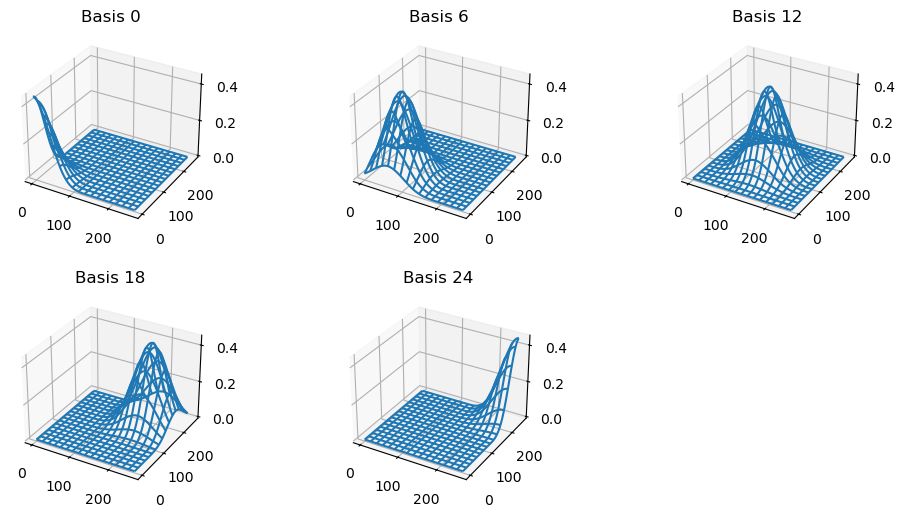

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

N1 = N2 = N
M1 = M2 = 5
h1 = (N1 - 1) / (M1 - 1)   # spacing in dim 1
h2 = (N2 - 1) / (M2 - 1)   # spacing in dim 2

x1 = np.arange(N1)
x2 = np.arange(N2)

# Initializie 1D basis matrices
Phi1 = np.zeros((N1, M1))
Phi2 = np.zeros((N2, M2))

# Build the matrices
for m in range(M1):
    Phi1[:, m] = eval_BSpline(x1 / h1 - m, order=3)

for m in range(M2):
    Phi2[:, m] = eval_BSpline(x2 / h2 - m, order=3)

# Kronecker product: 2D basis matrix
Phi = np.kron(Phi2, Phi1)   # shape (N1*N2, M1*M2)

# Visualize a few 2D basis functions
cols_to_plot = [0, 6, 12, 18, 24]
n_cols = len(cols_to_plot)

fig = plt.figure(figsize=(12, 6))

for idx, i in enumerate(cols_to_plot):
    
    # Determine row and column for 3+2 layout
    if idx < 3: # first 3 plots (row 1) 
        ax = fig.add_subplot(2, 3, idx+1, projection='3d')

    else:      # last 2 plots (row 2)
        ax = fig.add_subplot(2, 3, idx+1, projection='3d')

    basis_col = Phi[:, i].reshape(N1, N2, order="F")
    X, Y = np.meshgrid(np.arange(N2), np.arange(N1))
    ax.plot_wireframe(X, Y, basis_col, rstride=16, cstride=16)
    ax.set_title(f"Basis {i}")

plt.subplots_adjust(hspace=0.3)
plt.show()

Now:
- vectorize the 2D image $\mathbf{T}$ into a 1D signal $\mathbf{t}$
- smooth using $\boldsymbol{\Phi}$
- re-arrange the resulting 1D signal $\mathbf{\hat{t}}$ back into a 2D image $\mathbf{\hat{T}}$
- show the result.

>***Hints***: 
>* use ```T.reshape(-1, 1, order='F')``` and ```t.reshape(N1, N2, order='F')``` to vectorize and undo the vectorization.
>* do not explicitly compute the smoothing matrix $\mathbf{S}$ as it is very large!! Instead compute the weights $\mathbf{w} = (\boldsymbol{\Phi}^T \boldsymbol{\Phi})^{-1} \boldsymbol{\Phi}^T \mathbf{t}$ and expand those to get $\mathbf{\hat{t}} = \boldsymbol{\Phi} \mathbf{w}$.


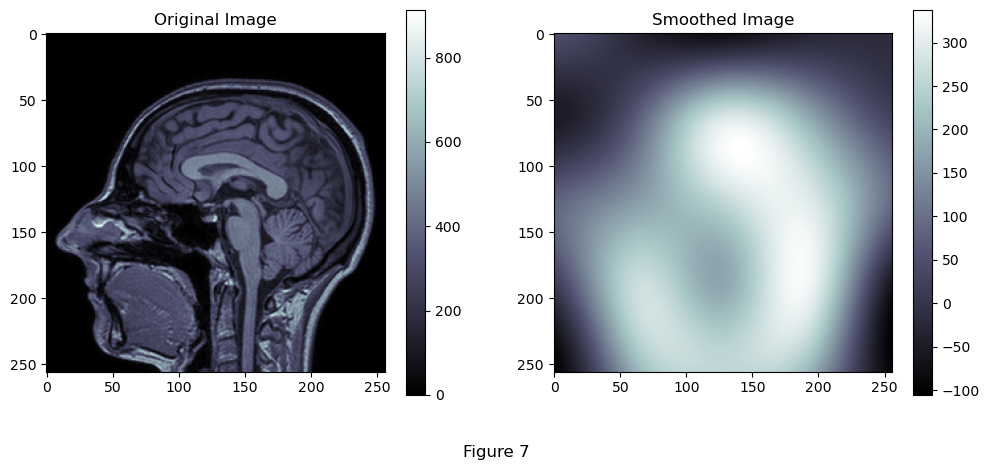

In [13]:
# Vectorize the 2D image
t = T.reshape(-1, 1, order='F') # [N1*N2, 1]

# Compute weights
# Solve w = (Phi^T Phi)^(-1) Phi^T t
w = np.linalg.solve(Phi.T @ Phi, Phi.T @ t)

# Smooth the vector t
t_smooth = Phi @ w   

# Reshape back to 2D
T_smooth = t_smooth.reshape(N1, N2, order='F')

# Display results
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(T, cmap='bone')
plt.title("Original Image")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(T_smooth, cmap='bone')
plt.title("Smoothed Image")
plt.colorbar()

plt.suptitle("Figure 7", y=0.01, fontsize=12)
plt.show()

Also perform the same smoothing operation by exploiting the separability of the 2D basis functions, i.e, perform row-wise and then column-wise smoothing instead. Show the results, and verify that they are identical (use ```np.allclose()```) 

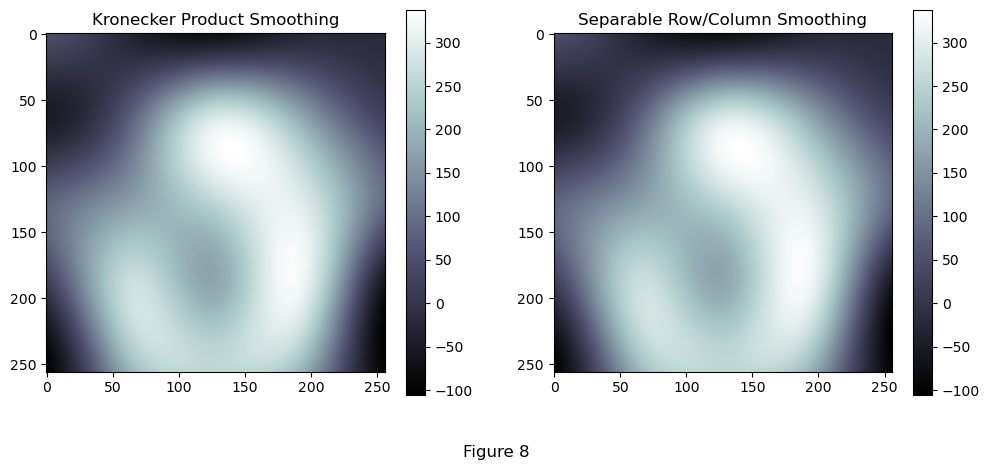

Are the two methods identical? True


In [14]:
# Compute intermediate matrices for separable smoothing
A1 = Phi1.T @ Phi1
A2 = Phi2.T @ Phi2

# Compute weight matrix W
temp = np.linalg.solve(A1, Phi1.T @ T @ Phi2)
W = np.linalg.solve(A2, temp.T).T  # [M1, M2]

# Smoothed image
T_smooth_sep = Phi1 @ W @ Phi2.T  # [N1, N2]

# Display results
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(T_smooth, cmap='bone')
plt.title("Kronecker Product Smoothing")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(T_smooth_sep, cmap='bone')
plt.title("Separable Row/Column Smoothing")
plt.colorbar()

plt.suptitle("Figure 8", y=0.01, fontsize=12)
plt.show()

# Verify that they are identical
print("Are the two methods identical?", np.allclose(T_smooth, T_smooth_sep))

#### Discussion

In this task the same smoothing performed in task 2 was applied to the full 2D image. First, two 1D basis matrices $\mathbf{\Phi_1} [N_1\times M_1]$ and $\mathbf{\Phi_2} [N_1\times M_1]$ were created respectively for the rows and the columns of the image. Then two different approaches were tested and compared, confirming the same output **[Fig.7-8]**:

##### 1) Kronecker product
In this method, the 2D smoothing problem is reformulated as a 1D problem by vectorizing the image **T** into **t**. Constructing the full smoothing matrix **S** would be computationally infeasible as it would contain all all possible pairwise interactions between image points $[N_1 N_2\times N_1 N_2]$. Instead, this approach computes only the spline coefficients directly by solving the least-squares problem $\mathbf{w} = (\boldsymbol{\Phi}^T \boldsymbol{\Phi})^{-1} \boldsymbol{\Phi}^T \mathbf{t}$ and then applying it to the vectorized image. Eventually, the smoothed 2D image is reconstructed by reshaping back the smoothed vector:

Phi = np.kron(Phi2, Phi1)  
w = np.linalg.solve(Phi.T @ Phi, Phi.T @ t)  
t_smooth = Phi @ w  

where $\mathbf{\Phi} [N_1 N_2\times M_1 M_2]$ is the 2D coefficients matrix obtained by the Kronecker product of the two 1D basis matrices $\mathbf{\Phi_1}$ and $\mathbf{\Phi_2}$

##### 2) Exploiting the separability of the 2D basis functions
In this method, the 2D smoothing is decomposed into two consecutive 1D problems. Specifically, instead of building a large Kronecker product basis matrix, the inverses $(\boldsymbol{\Phi}^T \boldsymbol{\Phi})^{-1}$ of both basis matrices are calculated separately for rows and columns and then used to get the weights matrix **W**. Afterwards the image was smoothed as $\mathbf{T_smooth}=\Phi_1 W \Phi_2^T$ which corresponds to performing smoothing along the rows and columns in sequence rather than simultaneously. This avoids vectorizing the image and is computationally more efficient, since it reduces the problem into two smaller 1D systems instead of a single large 2D one.

_Key Takeaways_

- Kronecker approach: applies a large 2D coefficient matrix (from the Kronecker product) directly to the vectorized image.
- Separable approach: applies smaller 1D coefficient matrices sequentially along rows and columns of the image.


---
### Task 5: 2D Interpolation
For B-spline order 0, 1 and 3, compute the weights $\mathbf{W}$ of the 2D interpolation model fitted to $\mathbf{T}$ by exploiting the separability of its basis functions. Then show, as an image, interpolated function values $y( \mathbf{x}, \mathbf{w})$ for $\mathbf{x}=(x_1, x_2)^T$ with:
- $x_1=120.0, 120.1, 120.2 \ldots, 130.0$ 
- $x_2=120.0, 120.1, 120.2 \ldots, 130.0$ 

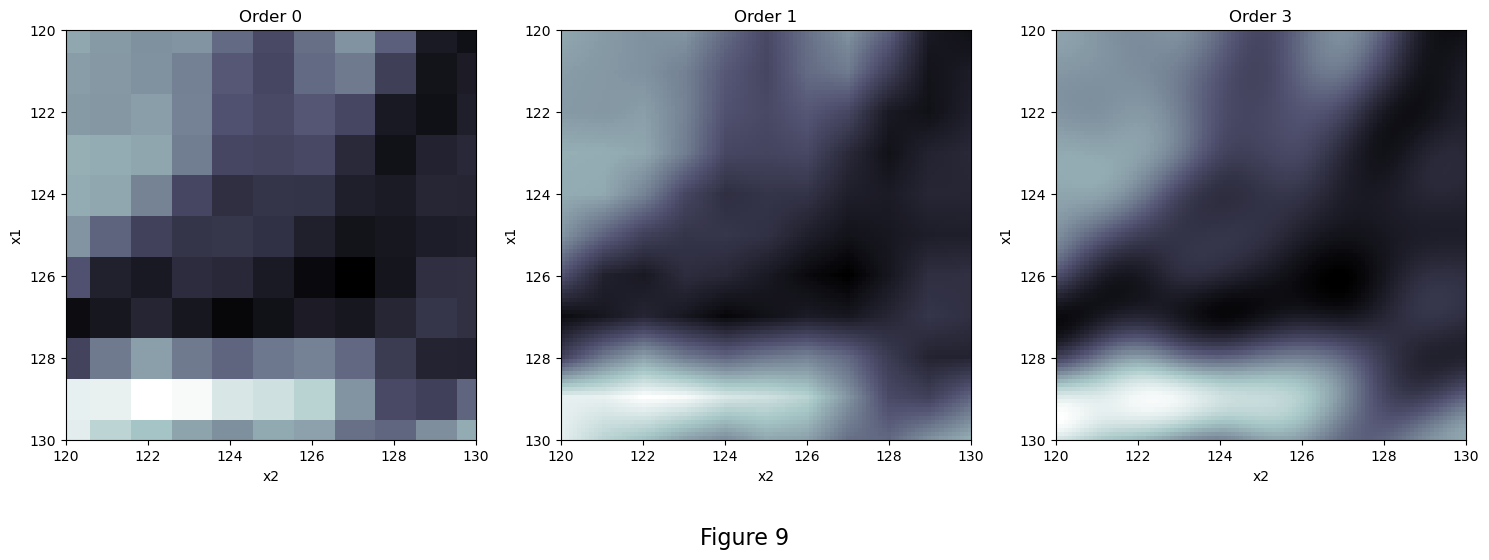

In [21]:
# evaluation points
x_eval = np.arange(120.0, 130.01, 0.1)
n_eval = len(x_eval)

x1 = np.arange(N1)
x2 = np.arange(N2)

# Orders to test
orders = [0, 1, 3]

fig, axes = plt.subplots(1, len(orders), figsize=(15,5))

for idx, order in enumerate(orders):

    # For each spline order, initialize the basis matrices
    Phi1 = np.zeros((N1, N1))
    Phi2 = np.zeros((N2, N2))

    # Build the matrices
    for i in range(N1):
        Phi1[:, i] = eval_BSpline(x1 - i, order)
    for i in range(N2):
        Phi2[:, i] = eval_BSpline(x2 - i, order)

    # Compute 2D weights using separability
    A1 = Phi1.T @ Phi1
    A2 = Phi2.T @ Phi2
    
    temp = np.linalg.solve(A1, Phi1.T @ T @ Phi2)
    W = np.linalg.solve(A2, temp.T).T

    # Compute 1D basis matrices at evaluation points
    Phi1_eval = np.zeros((n_eval, N1))
    Phi2_eval = np.zeros((n_eval, N2))
    for i in range(N1):
        Phi1_eval[:, i] = eval_BSpline(x_eval - i, order)
    for i in range(N2):
        Phi2_eval[:, i] = eval_BSpline(x_eval - i, order)

    # Compute interpolated image
    y_eval = Phi1_eval @ W @ Phi2_eval.T  # size: n_eval x n_eval

    # Display in corresponding subplot
    ax = axes[idx]
    im = ax.imshow(y_eval, extent=(x_eval[0], x_eval[-1], x_eval[-1], x_eval[0]),
                   origin='upper', cmap='bone')
    ax.set_title(f"Order {order}")
    ax.set_xlabel("x2")
    ax.set_ylabel("x1")

plt.suptitle("Figure 9", y=-0.1, fontsize=16)
plt.tight_layout()
plt.show()

#### Discussion
In this task, B-spline interpolation was applied to a local 2D image patch by exploiting the separability of the basis functions which allowed to efficiently compute the 2D interpolation weights $\mathbf{W}$ without constructing a full 2D basis matrix. The porcess was repeated 3 times using B-splines of order 0, 1 and 3 through the `eval_BSpline` function.

The resulting interpolated images **[Fig.9]** demonstrate the effect of spline order on smoothness and continuity:
- Order 0 produces a blocky, piecewise-constant interpolation with abrupt transitions between pixels.
- Order 1 yields a continuous, linear interpolation, smoothing out discontinuities while preserving local gradients.
- Order 3 provides a smooth, cubic interpolation, continuous up to the second derivative, giving a visually smoother reconstruction with gradual transitions across neighboring pixels.

## 3 Conclusion
In this project, we implemented and applied B-splines of different orders to a range of interpolation and smoothing problems in both 1D and 2D. The main findings are summarized as follows:

- _B-spline evaluation_: Higher-order splines produce smoother basis functions with wider support, giving more weight to neighboring points.

- _1D smoothing_: Spline-based smoothing effectively reduces noise while preserving the main signal trends.

- _1D interpolation_: Cubic B-splines ($p=3$) provide smooth and visually accurate reconstructions, although they reduce less noise compared to $p=0$ or $p=1$ splines.

- _2D smoothing_: B-splines extend naturally to two dimensions. Both the Kronecker product and separable approaches achieve similar results, enabling noise reduction in images without introducing harsh artifacts.

- _2D interpolation_: Cubic splines again provide the best trade-off between smoothness and accuracy, producing continuous reconstructions from sampled images.

Overall, the experiments confirm that B-splines, particularly cubic B-splines, are well-suited for interpolation and smoothing tasks. The stepwise progression from 1D to 2D demonstrates how the same mathematical framework scales across different types of data.